In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from tqdm.auto import trange

In [ ]:
url_a6tf ='https://drive.google.com/file/d/12V3p_jVKzrkMTLImFLxv_1YRymz5qTWG/view?usp=share_link'
url_a6tf='https://drive.google.com/uc?id=' + url_a6tf.split('/')[-2]
url_th ='https://drive.google.com/file/d/1XC-fCaBnDiQLm82sWfMuhzPJtIytDfuy/view?usp=share_link'
url_th='https://drive.google.com/uc?id=' + url_th.split('/')[-2]
url_tet ='https://docs.google.com/spreadsheets/d/1CkelCtYNUOi2VtMP7bY-XfstuGgWSL1f/edit?usp=share_link&ouid=101749734890205141586&rtpof=true&sd=true'
url_tet='https://drive.google.com/uc?id=' + url_tet.split('/')[-2]

In [ ]:
a6tf = pd.read_csv(url_a6tf)
a6tf[['Participant Private ID']] = a6tf[['Participant Private ID']].astype(int)
a6tf.drop('Participant Public ID', axis=1, inplace=True)
a6tf = a6tf.set_index('Participant Private ID')

a6tf['DoBRU-year'].fillna(a6tf['DoBRU-year'].median(), inplace=True)
a6tf.columns = ['Gender', 'Age', 'Education']


task_huav = pd.read_csv(url_th)
task_huav[['Participant Private ID']] = task_huav[['Participant Private ID']].astype(int)
task_huav.drop('Participant Public ID', axis=1, inplace=True)
task_huav = task_huav.set_index('Participant Private ID')
task_huav_con = task_huav[task_huav.columns[:3]]
task_huav_con.columns = ['Consent fair offer',
       'Consent conditionally fair offer', 'Consent unfair offer']


triada_empathy_tolerance = pd.read_excel(url_tet, index_col=1)
triada_empathy_tolerance.drop('Unnamed: 0', axis=1, inplace=True)

data = pd.concat([a6tf, triada_empathy_tolerance, task_huav_con], axis=1)

In [ ]:
data.head()

Gender   Age  Education  Machiavellianism  \
Participant Private ID                                              
6905533                      2  20.0          3                11   
6908178                      2  28.0          5                15   
7079747                      2  19.0          5                19   
7079758                      2  21.0          4                 9   
7081909                      2  20.0          3                10   

                        Psychopathy  Narcissism  Perspective-taking scale  \
Participant Private ID                                                      
6905533                           5          15                        22   
6908178                           6          17                        25   
7079747                          18          14                        21   
7079758                          10          18                        26   
7081909                          12          10                        24   

                        Fantasy scale  Empathic concern scale  \
Participant Private ID                                          
6905533                            35                      27   
6908178                            15                      29   
7079747                             7                       7   
7079758                            27                      23   
7081909                            19                      21   

                        Personal distress scale  Tolerance to uncertainty  \
Participant Private ID                                                      
6905533                                      24                        50   
6908178                                      17                        66   
7079747                                       7                        57   
7079758                                      26                        62   
7081909                                      21                        71   

                        Intolerance to uncertainty  \
Participant Private ID                               
6905533                                         49   
6908178                                         64   
7079747                                         69   
7079758                                         59   
7081909                                         41   

                        Interpersonal intolerance to uncertainty  \
Participant Private ID                                             
6905533                                                       46   
6908178                                                       30   
7079747                                                       29   
7079758                                                       44   
7081909                                                       36   

                        Consent fair offer  Consent conditionally fair offer  \
Participant Private ID                                                         
6905533                                  6                                 6   
6908178                                  6                                 6   
7079747                                  6                                 3   
7079758                                  5                                 4   
7081909                                  6                                 3   

                        Consent unfair offer  
Participant Private ID                        
6905533                                    0  
6908178                                   10  
7079747                                    0  
7079758                                    4  
7081909                                    0

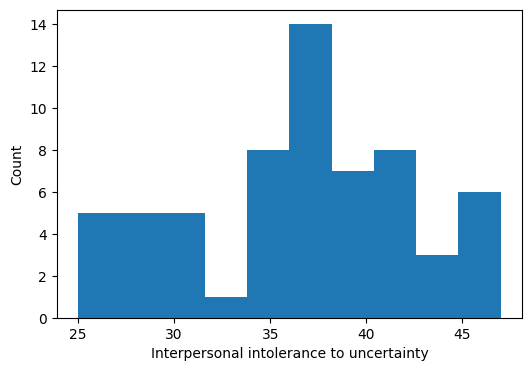

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(data["Interpersonal intolerance to uncertainty"])
plt.xlabel("Interpersonal intolerance to uncertainty")
plt.ylabel("Count");

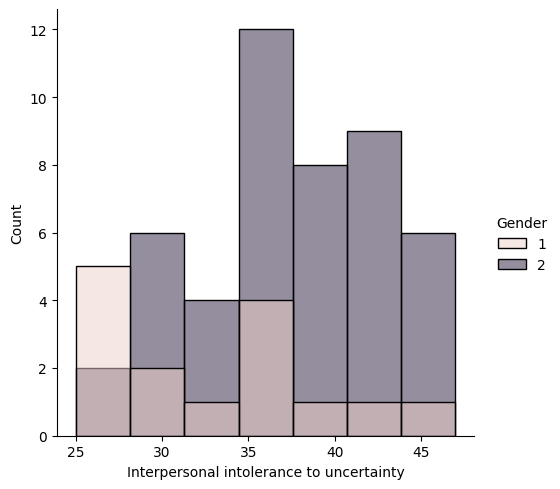

In [ ]:
sns.displot(data, x="Interpersonal intolerance to uncertainty", hue="Gender")
plt.show()

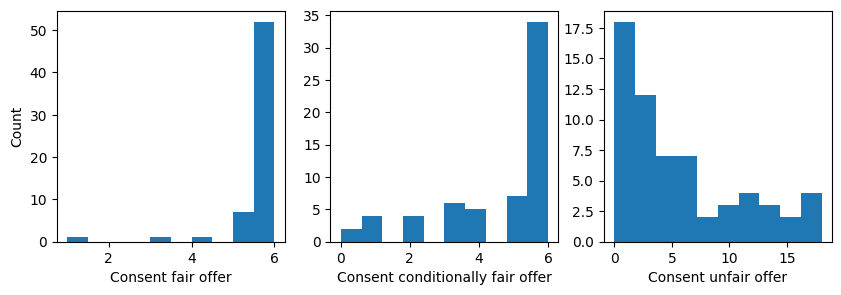

In [ ]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.hist(data["Consent fair offer"])
plt.ylabel("Count")
plt.xlabel("Consent fair offer")

plt.subplot(1, 3, 2)
plt.hist(data["Consent conditionally fair offer"])
plt.xlabel("Consent conditionally fair offer")

plt.subplot(1, 3, 3)
plt.hist(data["Consent unfair offer"])
plt.xlabel("Consent unfair offer")

plt.show()

In [ ]:
# sns.heatmap(data.corr(), cmap="vlag", annot=True, fmt="0.1f");

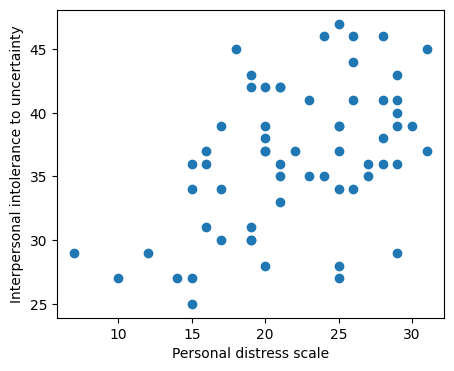

In [ ]:
plt.figure(figsize=(5, 4))
plt.scatter(data["Personal distress scale"], data["Interpersonal intolerance to uncertainty"])
plt.xlabel("Personal distress scale")
plt.ylabel("Interpersonal intolerance to uncertainty");

In [ ]:
X = data.iloc[:, :-3]
y = data.iloc[:, -3:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Масштабирование

In [ ]:
normalizer = preprocessing.MinMaxScaler()
X_train_norm = pd.DataFrame(normalizer.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(normalizer.transform(X_test), columns=X_test.columns)

Линейная регрессия без регуляризации

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 8.18966093857268
Test MSE: 21.257070536114252
Train R2: 0.3157315135538022
Test R2: -0.8434039895008049


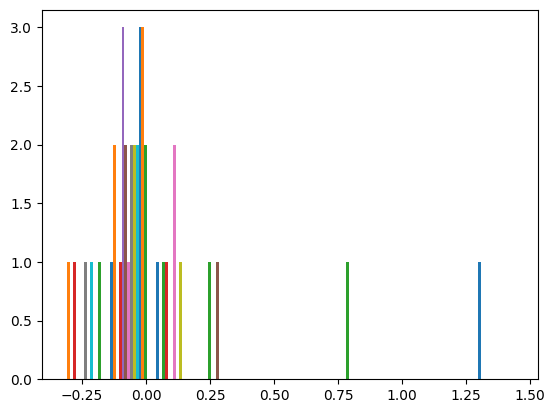

In [ ]:
plt.hist(lr.coef_);

Регуляризация на масштабированных данных

In [ ]:
lasso = Lasso(0.1).fit(X_train_norm, y_train)
pred_train = lasso.predict(X_train_norm)
pred_test = lasso.predict(X_test_norm)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 9.217117150729573
Test MSE: 15.53059466545225
Train R2: 0.09537782055025223
Test R2: -0.43227209774871916


In [ ]:
ridge = Ridge(5.0).fit(X_train_norm, y_train)
pred_train = ridge.predict(X_train_norm)
pred_test = ridge.predict(X_test_norm)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 9.610828591169236
Test MSE: 13.348546952378536
Train R2: 0.15367984887364175
Test R2: -0.35774882913053724


Можно попробовать удалить признаки, которые имеют низкую дисперсию, и посмотреть, как изменится качество

In [ ]:
features_variance = X_train_norm.var().sort_values(ascending=False)
features_variance.head()

Gender              0.160870
Education           0.106069
Machiavellianism    0.076200
Psychopathy         0.071482
Fantasy scale       0.069939
dtype: float64

In [ ]:
vs_transformer = VarianceThreshold(0.05)

X_train_var = pd.DataFrame(
    data=vs_transformer.fit_transform(X_train_norm),
    columns=X_train_norm.columns[vs_transformer.get_support()],
)
X_test_var = pd.DataFrame(
    data=vs_transformer.transform(X_test_norm),
    columns=X_test_norm.columns[vs_transformer.get_support()],
)

In [ ]:
lr = LinearRegression().fit(X_train_var, y_train)
pred_train = lr.predict(X_train_var)
pred_test = lr.predict(X_test_var)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 8.735283185341022
Test MSE: 18.577903316850726
Train R2: 0.2541857159529342
Test R2: -0.7095808605731854


Можно отобрать признаки с помощью L1-регуляризации

In [ ]:
lasso = Lasso(0.1)
l1_select = SelectFromModel(lasso)

X_train_l1 = pd.DataFrame(
    data=l1_select.fit_transform(X_train_var, y_train),
    columns=X_train_var.columns[l1_select.get_support()],
)
X_test_l1 = pd.DataFrame(
    data=l1_select.transform(X_test_var),
    columns=X_test_var.columns[l1_select.get_support()],
)

In [ ]:
lr = LinearRegression().fit(X_train_l1, y_train)
pred_train = lr.predict(X_train_l1)
pred_test = lr.predict(X_test_l1)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 8.793567754636923
Test MSE: 18.34049933615555
Train R2: 0.19187751924745536
Test R2: -0.6493567366158864


In [ ]:
pipe = Pipeline(
    steps=[
        ("scaler", preprocessing.MinMaxScaler()),
        ("variance", VarianceThreshold(0.05)),
        ("selection", SelectFromModel(Lasso(0.1))),
        ("regressor", Ridge(5.0)),
    ]
)

pipe.fit(X_train, y_train);

In [ ]:
pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 9.803741027163744
Test MSE: 12.840515052707088
Train R2: 0.11555920750328763
Test R2: -0.329484930006439


Подбор гиперпараметров

In [ ]:
param_grid = {
    "variance__threshold": [0.004, 0.005, 0.0055, 0.0059, 0.006, 0.065],
    "selection__estimator__alpha": np.linspace(0.01, 0.2, 21),
    "regressor__alpha": np.linspace(4, 6, 21),
}
grid_search = GridSearchCV(pipe, param_grid, cv=5)

grid_search.fit(X_train, y_train);

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('variance',
                                        VarianceThreshold(threshold=0.05)),
                                       ('selection',
                                        SelectFromModel(estimator=Lasso(alpha=0.1))),
                                       ('regressor', Ridge(alpha=5.0))]),
             param_grid={'regressor__alpha': array([4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ]),
                         'selection__estimator__alpha': array([0.01  , 0.0195, 0.029 , 0.0385, 0.048 , 0.0575, 0.067 , 0.0765,
       0.086 , 0.0955, 0.105 , 0.1145, 0.124 , 0.1335, 0.143 , 0.1525,
       0.162 , 0.1715, 0.181 , 0.1905, 0.2   ]),
                         'variance__threshold': [0.004, 0.005, 0.0055, 0.0059,
                                                 0.006, 0.065]})

In [ ]:
pipe_best = grid_search.best_estimator_
pipe_best.named_steps

{'scaler': MinMaxScaler(),
 'variance': VarianceThreshold(threshold=0.065),
 'selection': SelectFromModel(estimator=Lasso(alpha=0.09549999999999999)),
 'regressor': Ridge(alpha=6.0)}

In [ ]:
pred_train = pipe_best.predict(X_train)
pred_test = pipe_best.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 10.73394680649504
Test MSE: 11.64374168702121
Train R2: 0.06305410929530753
Test R2: -0.259554625798409


Дерево глубины 3. “Fantasy scale”, скорее всего, важный признак.

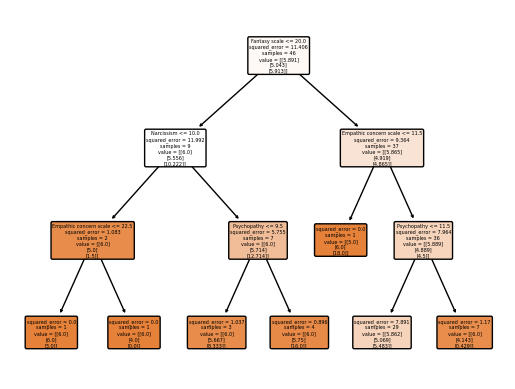

In [ ]:
dt = DecisionTreeRegressor(max_depth=3, random_state=0)
dt.fit(X_train, y_train)

plot_tree(dt, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

In [ ]:
pred_train = dt.predict(X_train)
pred_test = dt.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 5.298597724947051
Test MSE: 16.901072354435566
Train R2: 0.3010824020641069
Test R2: -0.5331453044688775


При увеличении глубины дерева MSE сначала должна уменьшаться, а затем с некоторого значения возрастать (неглубокое дерево недообучено, глубокое - переобучено). Видимо, из-за недостаточного количества данных эту зависимость не удается увидеть.

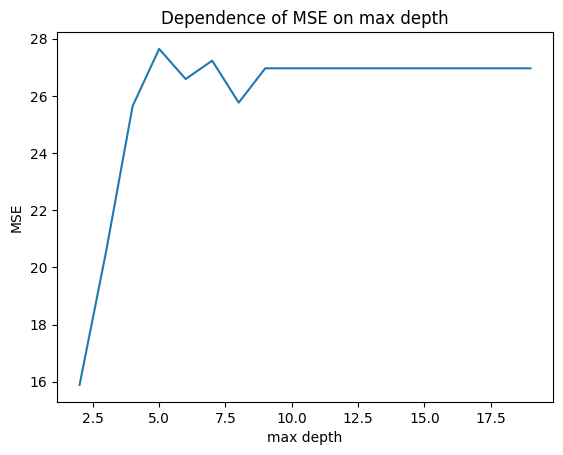

In [ ]:
max_depth_array = range(2, 20)
mse_array = []

for max_depth in max_depth_array:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
    score = -cross_val_score(dt, X, y, cv=3, scoring="neg_mean_squared_error").mean()
    mse_array.append(score)

plt.plot(max_depth_array, mse_array)
plt.title("Dependence of MSE on max depth")
plt.xlabel("max depth")
plt.ylabel("MSE");

In [ ]:
pd.DataFrame({"max_depth": max_depth_array, "MSE": mse_array}).sort_values(
    by="MSE"
).reset_index(drop=True).head()

max_depth        MSE
0          2  15.886932
1          3  20.552046
2          4  25.642643
3          8  25.761934
4          6  26.589187

При малых значениях “min_samples_leaf” должны наблюдать переобучение, при больших - недообучение.

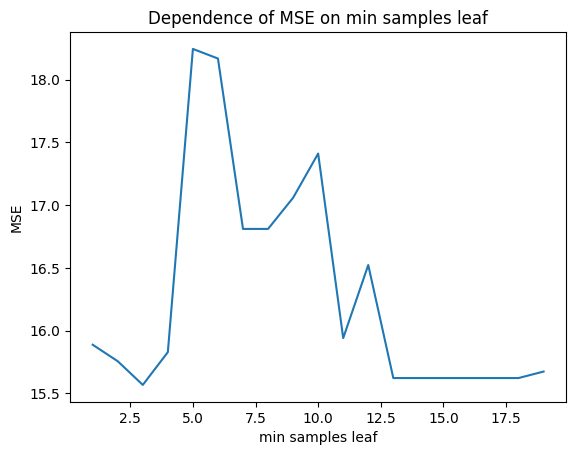

In [ ]:
min_samples_leaf_array = range(1, 20)
mse_array = []

for min_samples_leaf in min_samples_leaf_array:
    dt = DecisionTreeRegressor(
        max_depth=2, min_samples_leaf=min_samples_leaf, random_state=13
    )
    score = -cross_val_score(dt, X, y, cv=3, scoring="neg_mean_squared_error").mean()
    mse_array.append(score)

plt.plot(min_samples_leaf_array, mse_array)
plt.title("Dependence of MSE on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("MSE");

In [ ]:
pd.DataFrame({"min_samples_leaf": min_samples_leaf_array, "MSE": mse_array}).sort_values(
    by="MSE"
).reset_index(drop=True).head()

min_samples_leaf        MSE
0                 3  15.566753
1                17  15.621588
2                16  15.621588
3                15  15.621588
4                14  15.621588

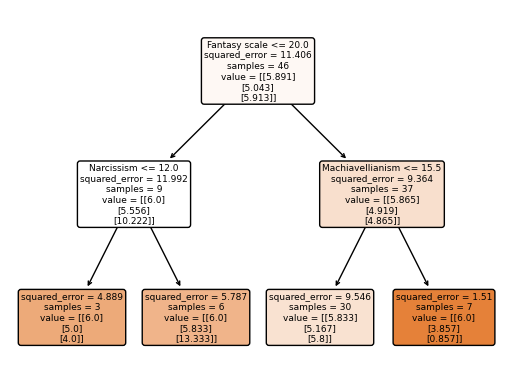

In [ ]:
dt = DecisionTreeRegressor(max_depth=2, min_samples_leaf=3, random_state=13)
dt.fit(X_train, y_train)

plot_tree(dt, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

In [ ]:
pred_train = dt.predict(X_train)
pred_test = dt.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 7.529089026915115
Test MSE: 13.93710648148148
Train R2: 0.1838357502829373
Test R2: -0.39868380969675493


In [ ]:
dt.feature_importances_

array([0.        , 0.        , 0.        , 0.27767424, 0.        ,
       0.32824049, 0.        , 0.39408527, 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [ ]:
pd.DataFrame(
    {"feature": X.columns, "importance": dt.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True).head(3)

feature  importance
0     Fantasy scale    0.394085
1        Narcissism    0.328240
2  Machiavellianism    0.277674

Дерево без ограничений

In [ ]:
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train, y_train)

pred_train = dt.predict(X_train)
pred_test = dt.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 0.0
Test MSE: 32.416666666666664
Train R2: 1.0
Test R2: -1.5040509615174555


Бэггинг

In [ ]:
bag = BaggingRegressor(dt, n_estimators=20, random_state=0)
bag.fit(X_train, y_train)

pred_train = bag.predict(X_train)
pred_test = bag.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 2.76998188405797
Test MSE: 17.209114583333335
Train R2: 0.781178618603533
Test R2: -0.48388189730175307


Случайный лес (добавляем рандомизацию по признакам)

In [ ]:
rf = RandomForestRegressor(n_estimators=20, max_features="sqrt", random_state=0)
rf.fit(X_train, y_train)

pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, pred_test)}")
print(f"Train R2: {r2_score(y_train, pred_train)}")
print(f"Test R2: {r2_score(y_test, pred_test)}")

Train MSE: 2.423768115942029
Test MSE: 14.88828125
Train R2: 0.8092182005791608
Test R2: -0.4318412950203152


  0%|          | 0/50 [00:00<?, ?it/s]

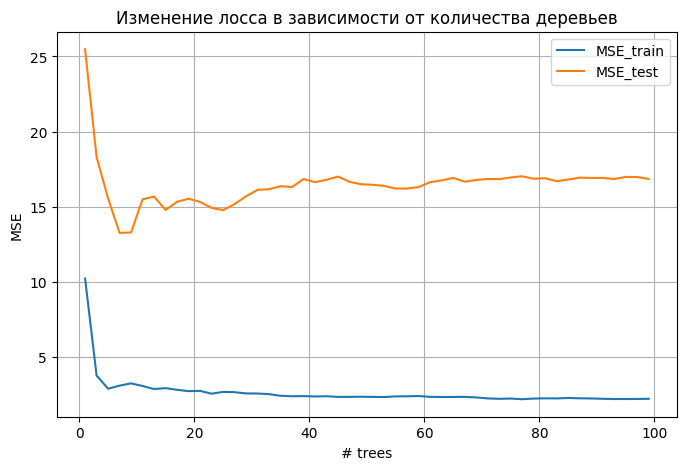

In [ ]:
n_trees = 100
train_loss = []
test_loss = []

for i in trange(1, n_trees, 2):
    rf = RandomForestRegressor(n_estimators=i, random_state=0)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(8, 5))
plt.title("Изменение лосса в зависимости от количества деревьев")
plt.grid()
plt.plot(np.arange(1, n_trees, 2), train_loss, label="MSE_train")
plt.plot(np.arange(1, n_trees, 2), test_loss, label="MSE_test")
plt.ylabel("MSE")
plt.xlabel("# trees")
plt.legend();

Число деревьев зафиксировано, меняем глубину

  0%|          | 0/25 [00:00<?, ?it/s]

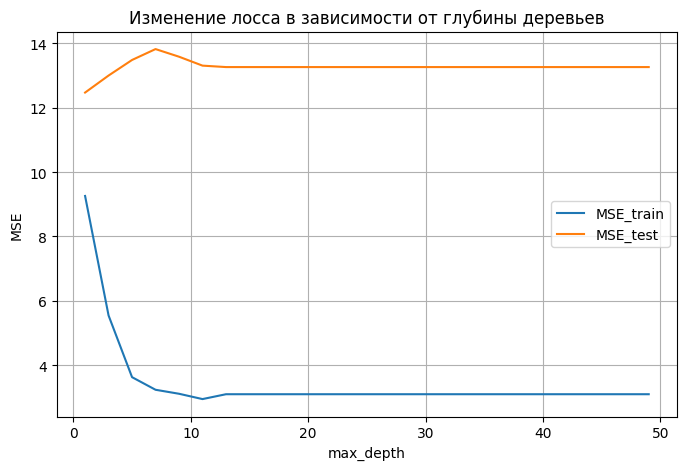

In [ ]:
max_depth = 50
train_loss = []
test_loss = []

for i in trange(1, max_depth, 2):
    rf = RandomForestRegressor(n_estimators=7, max_depth=i, random_state=0)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(8, 5))
plt.title("Изменение лосса в зависимости от глубины деревьев")
plt.grid()
plt.plot(np.arange(1, max_depth, 2), train_loss, label="MSE_train")
plt.plot(np.arange(1, max_depth, 2), test_loss, label="MSE_test")
plt.ylabel("MSE")
plt.xlabel("max_depth")
plt.legend();

In [ ]:
rf = RandomForestRegressor(n_estimators=7, max_depth=11, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, n_estimators=7, random_state=0)

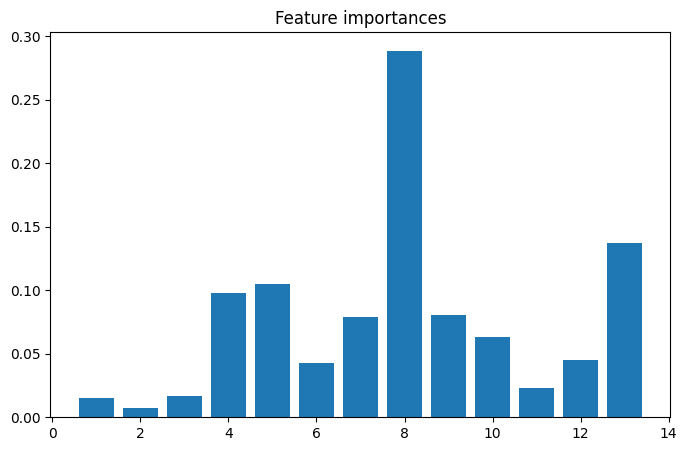

In [ ]:
plt.figure(figsize=(8, 5))
plt.title("Feature importances")
plt.bar(np.arange(1, 14), rf.feature_importances_);